In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
import itertools
import os
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

In [14]:
# A function to calulate "Reactions per Pathway %" for each phenotype
def Calculate_Enrichment_Coverage(enrich,sko_summ,target_col):
    enrich_coverage = enrich
    phenotypes =  sko_summ.index 
    for j in range(sko_summ.shape[0]):
        enrich_coverage[phenotypes[j]] = np.zeros((enrich.shape[0],1))
        query_genes = sko_summ.loc[phenotypes[j],target_col]
        query_genes = query_genes.split('; ')# for x in query_genes]
        #query_genes  =np.unique(np.concatenate(query_genes))
        query_genes = [x for x in query_genes if x not in ['NaN','nan']]
        for i in range(enrich.shape[0]):
            enrich_genes = enrich.Genes[i].split(';')
            shared_genes = [x for x in query_genes if x in enrich_genes]
            total_path_genes = int(enrich.Overlap[i].split('/')[1])
            enrich_coverage[phenotypes[j]][i] = len(shared_genes)/total_path_genes#len(enrich_genes)
            enrich_coverage.index = enrich_coverage.Term
    return enrich_coverage

In [15]:
from gseapy.parser import Biomart

bm = Biomart(verbose=False, host="europe.ensembl.org")
## view validated marts
marts = bm.get_marts()
## view validated dataset
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
## view validated attributes
attrs = bm.get_attributes(dataset='hsapiens_gene_ensembl')
## view validated filters
filters = bm.get_filters(dataset='hsapiens_gene_ensembl')

In [16]:
marts

,Name,Description
0,ENSEMBL_MART_ENSEMBL,Ensembl Genes 103
1,ENSEMBL_MART_MOUSE,Mouse strains 103
2,ENSEMBL_MART_SEQUENCE,Sequence
3,ENSEMBL_MART_ONTOLOGY,Ontology
4,ENSEMBL_MART_GENOMIC,Genomic features 103
5,ENSEMBL_MART_SNP,Ensembl Variation 103
6,ENSEMBL_MART_FUNCGEN,Ensembl Regulation 103


### Calculate phenotype safety and toxicity in the SKO

In [24]:
## Calculate phenotype toxicity and essentially  for the severity study

sko = pd.read_csv('./KO_data/severity_SKO_All.csv')
sko = sko.astype('object')
sko["SKO_Unkown"] =sko["SKO_Unkown"].apply(lambda x: str(x).split('.')[0])
sko.Series = sko.Series.str.upper()
sko['RECON'] = sko.RECON.str.replace('.mat','').str.upper().str.replace('RECON','')
sko['All_genes'] = sko.SKO_Safe.astype('str')+','+sko.SKO_Toxic.astype('str')+','+sko.SKO_Unkown.astype('str')

In [31]:
sko

,Series,RECON,SKO_Safe,SKO_Toxic,SKO_Unknown,All_genes
0,CALU3_12H,2,"10999,51477","259230,2987,54675,8140",NaN,"10999,51477,259230,2987,54675,8140"
1,CALU3_12H,3D,8140,"23657,259230,2987,51477,5184,54675,6520",NaN,"8140,23657,259230,2987,51477,5184,54675,6520"
2,CALU3_24H,2,NaN,"10999,259230,2987,51477,54675,8140",NaN,"nan,10999,259230,2987,51477,54675,8140"
3,CALU3_24H,3D,9791,"23657,2987,51228,51477,54675,6520",NaN,"9791,23657,2987,51228,51477,54675,6520"
4,CALU3_4H,2,NaN,"10999,259230,2987,54675",NaN,"nan,10999,259230,2987,54675"
5,CALU3_4H,3D,51228,"23657,259230,2987,51477,5184,54675,6520",NaN,"51228,23657,259230,2987,51477,5184,54675,6520"
6,CALU3_8H,2,NaN,NaN,"54675,8140,2987,10999,259230","nan,nan"
7,CALU3_8H,3D,NaN,NaN,"6520,54675,23657,51477,259230,5184,2987,51228","nan,nan"
8,H1299_12H,2,NaN,NaN,"9057,54675,1491,10999,5338,259230","nan,nan"
9,H1299_12H,3D,NaN,NaN,"54675,51477,259230,5184","nan,nan"


In [26]:
sko_gene_list = sko.All_genes.tolist()
sko_gene_list = [x.split(',') for x in sko_gene_list]
sko_gene_list = np.unique(np.concatenate(sko_gene_list)).tolist()[:-1]
results = bm.query(dataset='hsapiens_gene_ensembl', attributes=['entrezgene_id','hgnc_symbol'],#, 'go_id'],
                      filters={'entrezgene_id': sko_gene_list})
results =  results.dropna().drop_duplicates().reset_index(drop=True)

In [27]:
sko_db = pd.DataFrame()
sko_db['Gene_Symbol'] = int(0)
sko_db['Genes'] = sko_gene_list
sko_db['Phenotype_Essentiality'] = 0
sko_db['Phenotype_Safety'] = int(0)
for i in range(sko_db.shape[0]):
    entrez = sko_gene_list[i]
    gene = results.loc[results.entrezgene_id == int(entrez),'hgnc_symbol'].values[0]
    sko_db.loc[i,'Gene_Symbol'] =  gene
    sko_db.loc[i,'Phenotype_Essentiality'] = str(sko.All_genes).count(str(entrez))
    sko_db.loc[i,'Phenotype_Safety'] = str(sko.SKO_Safe).count(str(entrez))
sko_db.index = sko_db.Gene_Symbol
sko_db.to_csv('KO_data/severity_SKO_Toxicity_Phenotype_db.csv')

In [28]:
sko_db

,Gene_Symbol,Genes,Phenotype_Essentiality,Phenotype_Safety
Gene_Symbol,,,,
SLC27A4,SLC27A4,10999,3,2
SLC7A9,SLC7A9,11136,2,2
SLC2A13,SLC2A13,114134,1,0
CTH,CTH,1491,2,1
DHFR,DHFR,1719,1,1
DTYMK,DTYMK,1841,1,1
AGXT,AGXT,189,1,1
SLC7A11,SLC7A11,23657,2,1
SGMS1,SGMS1,259230,11,0


In [32]:
## Calculate phenotype toxicity and essentially  for the timeseries study
sko = pd.read_csv('./KO_data/timeseries_SKO_All.csv')
sko = sko.astype('object')
sko.Series = sko.Series.str.upper()
sko['RECON'] = sko.RECON.str.replace('.mat','').str.upper().str.replace('RECON','')
sko['All_genes'] = sko.SKO_Safe.astype('str')+','+sko.SKO_Toxic.astype('str')

In [33]:
sko

,Series,RECON,SKO_Safe,SKO_Toxic,SKO_Unknown,All_genes
0,CALU3_12H,2,"10999,51477","259230,2987,54675,8140",NaN,"10999,51477,259230,2987,54675,8140"
1,CALU3_12H,3D,8140,"23657,259230,2987,51477,5184,54675,6520",NaN,"8140,23657,259230,2987,51477,5184,54675,6520"
2,CALU3_24H,2,NaN,"10999,259230,2987,51477,54675,8140",NaN,"nan,10999,259230,2987,51477,54675,8140"
3,CALU3_24H,3D,9791,"23657,2987,51228,51477,54675,6520",NaN,"9791,23657,2987,51228,51477,54675,6520"
4,CALU3_4H,2,NaN,"10999,259230,2987,54675",NaN,"nan,10999,259230,2987,54675"
5,CALU3_4H,3D,51228,"23657,259230,2987,51477,5184,54675,6520",NaN,"51228,23657,259230,2987,51477,5184,54675,6520"
6,CALU3_8H,2,NaN,NaN,"54675,8140,2987,10999,259230","nan,nan"
7,CALU3_8H,3D,NaN,NaN,"6520,54675,23657,51477,259230,5184,2987,51228","nan,nan"
8,H1299_12H,2,NaN,NaN,"9057,54675,1491,10999,5338,259230","nan,nan"
9,H1299_12H,3D,NaN,NaN,"54675,51477,259230,5184","nan,nan"


In [34]:
sko_gene_list = sko.All_genes.tolist()
sko_gene_list = [x.split(',') for x in sko_gene_list]
sko_gene_list = np.unique(np.concatenate(sko_gene_list)).tolist()[:-1]
results = bm.query(dataset='hsapiens_gene_ensembl', attributes=['entrezgene_id','hgnc_symbol'],#, 'go_id'],
                      filters={'entrezgene_id': sko_gene_list})
results =  results.dropna().drop_duplicates().reset_index(drop=True)

In [35]:
sko_db = pd.DataFrame()
sko_db['Gene_Symbol'] = int(0)
sko_db['Genes'] = sko_gene_list
sko_db['Phenotype_Essentiality'] = 0
sko_db['Phenotype_Safety'] = int(0)
for i in range(sko_db.shape[0]):
    entrez = sko_gene_list[i]
    gene = results.loc[results.entrezgene_id == int(entrez),'hgnc_symbol'].values[0]
    sko_db.loc[i,'Gene_Symbol'] =  gene
    sko_db.loc[i,'Phenotype_Essentiality'] = str(sko.All_genes).count(str(entrez))
    sko_db.loc[i,'Phenotype_Safety'] = str(sko.SKO_Safe).count(str(entrez))
sko_db.index = sko_db.Gene_Symbol
sko_db.to_csv('KO_data/timeseries_SKO_Toxicity_Phenotype_db.csv')

In [36]:
sko_db

,Gene_Symbol,Genes,Phenotype_Essentiality,Phenotype_Safety
Gene_Symbol,,,,
SLC27A4,SLC27A4,10999,5,1
CTH,CTH,1491,2,1
SLC7A11,SLC7A11,23657,3,0
SGMS1,SGMS1,259230,9,0
GUK1,GUK1,2987,6,0
GLTP,GLTP,51228,2,1
ISYNA1,ISYNA1,51477,7,1
PEPD,PEPD,5184,3,1
PLD2,PLD2,5338,2,0


In [37]:
### Merge the 2 lung studies
lung_1 =pd.read_csv('KO_data/severity_SKO_Toxicity_Phenotype_db.csv')
lung_2 =pd.read_csv('KO_data/timeseries_SKO_Toxicity_Phenotype_db.csv')

In [38]:
df_final = pd.merge(lung_1, lung_2, on = ['Genes','Gene_Symbol'], how = 'outer')#lung_1.merge(lung_2, left_on='Genes', right_on='Genes')
df_final.index = df_final.Gene_Symbol
df_final = df_final.fillna(0)
df_final = df_final.loc[:,['Genes','Phenotype_Safety_x','Phenotype_Essentiality_x','Phenotype_Safety_y','Phenotype_Essentiality_y','Gene_Symbol']]
df_final['Phenotype_Essentiality'] = df_final['Phenotype_Essentiality_x']+ df_final['Phenotype_Essentiality_y']
df_final['Phenotype_Safety'] = df_final['Phenotype_Safety_x']+ df_final['Phenotype_Safety_y']
#df = df.drop(columns =['Gene_Symbol'])
df_final.iloc[:,-2:] = df_final.iloc[:,-2:].astype('int')
df_final = df_final.sort_values('Phenotype_Essentiality',ascending=False)
# Replacing 0 by 1 since the count was taken by average of the 2 recon models
#df_final['Phenotype_Essentiality'] = df_final['Phenotype_Essentiality'].replace(0,1)
#df_final['Phenotype_Essentiality'] = df_final['Phenotype_Essentiality'].replace(-1,1)

df_final['Phenotype_Safety'] = df_final['Phenotype_Safety'].replace(0,1)

df_final

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety
Gene_Symbol,,,,,,,,
CRLS1,54675,0.0,12.0,0.0,10.0,CRLS1,22,1
SGMS1,259230,0.0,11.0,0.0,9.0,SGMS1,20,1
GUK1,2987,3.0,10.0,0.0,6.0,GUK1,16,3
ISYNA1,51477,0.0,2.0,1.0,7.0,ISYNA1,9,1
SLC27A4,10999,2.0,3.0,1.0,5.0,SLC27A4,8,3
PEPD,5184,1.0,4.0,1.0,3.0,PEPD,7,2
SLC3A2,6520,1.0,2.0,0.0,3.0,SLC3A2,5,1
SLC7A11,23657,1.0,2.0,0.0,3.0,SLC7A11,5,1
PTDSS1,9791,2.0,3.0,1.0,1.0,PTDSS1,4,3


In [39]:
df_final.loc[:,['Genes','Gene_Symbol','Phenotype_Essentiality','Phenotype_Safety']]

,Genes,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety
Gene_Symbol,,,,
CRLS1,54675,CRLS1,22,1
SGMS1,259230,SGMS1,20,1
GUK1,2987,GUK1,16,3
ISYNA1,51477,ISYNA1,9,1
SLC27A4,10999,SLC27A4,8,3
PEPD,5184,PEPD,7,2
SLC3A2,6520,SLC3A2,5,1
SLC7A11,23657,SLC7A11,5,1
PTDSS1,9791,PTDSS1,4,3


In [40]:
df_final.loc[:,['Genes','Gene_Symbol','Phenotype_Essentiality','Phenotype_Safety']].to_csv('SKO_ALL_Studies.csv')

In [41]:
# Genes from both lung studies
df_final.index

Index(['CRLS1', 'SGMS1', 'GUK1', 'ISYNA1', 'SLC27A4', 'PEPD', 'SLC3A2',
       'SLC7A11', 'PTDSS1', 'CMPK1', 'CTH', 'SLC5A3', 'SLC7A5', 'SLC7A9',
       'SLC3A1', 'GLTP', 'PLD2', 'SLC7A6', 'AGXT', 'DTYMK', 'DHFR', 'TYMS',
       'SLC2A13'],
      dtype='object', name='Gene_Symbol')

In [42]:
df_final.shape

(23, 8)

## SKO Drug Repurposing

In [43]:
# Drug Repurposing
drugbank_df  =pd.read_csv('./DrugBank_Drug_Target_Toxicity_Only_Indication.csv',sep=',',index_col=0)
#drugbank_df = drugbank_df.drop(columns = ['drugbank_id.1'])
drugbank_df.head(10)

,drugbank_id,category,uniprot_id,entrez_gene_id,organism,known_action,actions,pubmed_ids,name,type,groups,atc_codes,categories,description,hgnc_symbol,umls_cui_from_meddra,side_effect_name,Meddra_Indication
0,DB00001,target,P00734,2147,Humans,yes,inhibitor,NaN,Lepirudin,biotech,approved,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",Lepirudin is identical to natural hirudin exce...,RET,NaN,NaN,NaN
1,DB00006,target,P00734,2147,Humans,yes,inhibitor,NaN,Bivalirudin,small molecule,approved|investigational,B01AE06,"Amino Acids, Peptides, and Proteins|Anticoagul...",Bivalirudin is a synthetic 20 residue peptide ...,RET,NaN,NaN,NaN
2,DB00025,enzyme,P00734,2147,Humans,unknown,activator,NaN,"Antihemophilic factor, human recombinant",biotech,approved|investigational,B02BD02,"Amino Acids, Peptides, and Proteins|Biological...",Human recombinant antihemophilic factor (AHF) ...,RET,NaN,NaN,NaN
3,DB00055,target,P00734,2147,Humans,unknown,NaN,NaN,Drotrecogin alfa,biotech,approved|investigational|withdrawn,B01AD10,"Amino Acids, Peptides, and Proteins|Anti-Infec...",Drotrecogin alfa is activated human protein C ...,RET,NaN,NaN,NaN
4,DB00100,target,P00734,2147,Humans,unknown,NaN,NaN,Coagulation Factor IX (Recombinant),biotech,approved|investigational,NaN,Blood Coagulation Factors|Hemostatics|Increase...,Recombinant Coagulation Factor IX is a purifie...,RET,NaN,NaN,NaN
5,DB00170,target,P00734,2147,Humans,unknown,activator,NaN,Menadione,small molecule,approved|nutraceutical,B02BA02,Antifibrinolytic Agents|Blood and Blood Formin...,A synthetic naphthoquinone without the isopren...,RET,NaN,NaN,NaN
6,DB00278,target,P00734,2147,Humans,yes,inhibitor,NaN,Argatroban,small molecule,approved|investigational,B01AE03,Anticoagulants|Antithrombins|Blood and Blood F...,"Argatroban is a direct, selective thrombin inh...",RET,NaN,NaN,"['Acute myocardial infarction', 'Heparin-induc..."
7,DB01123,target,P00734,2147,Humans,no,other/unknown,NaN,Proflavine,small molecule,approved,NaN,Acridines|Aminoacridines|Anti-Infective Agents...,"3,6-Diaminoacridine. Topical antiseptic used m...",RET,NaN,NaN,NaN
8,DB01593,target,P00734,2147,Humans,unknown,NaN,NaN,Zinc,small molecule,approved|investigational,C05AX04,Agents for Treatment of Hemorrhoids and Anal F...,A metallic element of atomic number 30 and ato...,RET,NaN,NaN,"['Foetor hepaticus', 'Hepato-lenticular degene..."
9,DB01725,target,P00734,2147,Humans,unknown,NaN,NaN,"2-{2-hydroxy-[1,1'-biphenyl]-3-yl}-1H-1,3-benz...",small molecule,experimental,NaN,NaN,NaN,RET,NaN,NaN,NaN


In [44]:
# Replace drug name for large name by drug id
drugbank_df.loc[drugbank_df.name.apply(lambda x:len(x))>30,'name'] =drugbank_df.loc[drugbank_df.name.apply(lambda x:len(x))>30,'drugbank_id']

In [45]:
# Since the same drug different approval groups on different entries, we will unify them by concatenating
drugbank_drugs = np.unique(drugbank_df.name)
for drug in drugbank_drugs:
    drugbank_df.loc[drugbank_df.name ==drug,'groups'] = '|'.join(np.unique(drugbank_df.loc[drugbank_df.name ==drug,'groups']).tolist())

In [46]:
drugbank_df.head()

,drugbank_id,category,uniprot_id,entrez_gene_id,organism,known_action,actions,pubmed_ids,name,type,groups,atc_codes,categories,description,hgnc_symbol,umls_cui_from_meddra,side_effect_name,Meddra_Indication
0,DB00001,target,P00734,2147,Humans,yes,inhibitor,NaN,Lepirudin,biotech,approved,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",Lepirudin is identical to natural hirudin exce...,RET,NaN,NaN,NaN
1,DB00006,target,P00734,2147,Humans,yes,inhibitor,NaN,Bivalirudin,small molecule,approved|investigational,B01AE06,"Amino Acids, Peptides, and Proteins|Anticoagul...",Bivalirudin is a synthetic 20 residue peptide ...,RET,NaN,NaN,NaN
2,DB00025,enzyme,P00734,2147,Humans,unknown,activator,NaN,DB00025,biotech,approved|investigational,B02BD02,"Amino Acids, Peptides, and Proteins|Biological...",Human recombinant antihemophilic factor (AHF) ...,RET,NaN,NaN,NaN
3,DB00055,target,P00734,2147,Humans,unknown,NaN,NaN,Drotrecogin alfa,biotech,approved|investigational|withdrawn,B01AD10,"Amino Acids, Peptides, and Proteins|Anti-Infec...",Drotrecogin alfa is activated human protein C ...,RET,NaN,NaN,NaN
4,DB00100,target,P00734,2147,Humans,unknown,NaN,NaN,DB00100,biotech,approved|investigational,NaN,Blood Coagulation Factors|Hemostatics|Increase...,Recombinant Coagulation Factor IX is a purifie...,RET,NaN,NaN,NaN


In [47]:
#drugbank_df_inhibitor = drugbank_df.loc[drugbank_df.actions.astype('str').str.contains('inhibitor'),:]
#drugbank_df_inducer = drugbank_df.loc[drugbank_df.actions.astype('str').str.contains('inducer'),:]

In [48]:
# Map full gene name describtion
#gene_desc = drugbank_df[['SYMBOL','entrez_gene_id','Name']].drop_duplicates()
#gene_desc = gene_desc.dropna()
#gene_desc.entrez_gene_id= gene_desc.entrez_gene_id.apply(lambda x: int(x))

In [49]:
df_final.Genes = df_final.Genes.astype('int')

In [50]:
gtex_db = df_final #pd.concat([sko_db_safe,sko_db_some_toxic])
df = pd.DataFrame(np.zeros((1000,len(gtex_db.columns))),columns = gtex_db.columns)
df['Drugs']= 0
df['Drugs_Action'] = 0
df['Gene_Symbol'] = 0
#df = df.astype('object')
k = 0
for i in range(gtex_db.shape[0]):
    gene = gtex_db.iloc[i,0]
    if gene in drugbank_df.entrez_gene_id.tolist():
        drugs = list(set(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'name']))
        for l in range(len(drugs)):
            df.loc[k,'Genes'] = gene
            df.iloc[k,1:] = gtex_db.iloc[i,1:]

            df.loc[k,'Drugs'] = drugs[l]
            df.loc[k,'Drugs_Action'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'actions'])[l]
            #df.loc[k,'Gene_Symbol'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'hgnc_symbol'])[l]
            df.loc[k,'Drugs_Group'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'groups'])[l]
            df.loc[k,'ATC_Code'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'atc_codes'])[l]
            df.loc[k,'Gene_Categories'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'category'])[l]
            df.loc[k,'Drugs_Categories'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'categories'])[l]
            df.loc[k,'side_effect_name'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'side_effect_name'])[l]
            df.loc[k,'Meddra_Indication'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'Meddra_Indication'])[l]

            #df.loc[k,'Gene_Name'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'Name'])[l]
            k = k+1
    else:
        pass
df = df.loc[df.Drugs!=0,:]
#df.to_csv('Drug_Repurposing_Results/GTEx_SKO_Safe_Drugs.csv')

In [51]:
df_final['Gene_Symbol'] = df_final.index
df['Gene_Symbol'] = df.Genes.map(df_final.set_index('Genes')['Gene_Symbol'])

In [52]:
df = df.loc[df.Genes!=0,:] 

In [53]:
df.head(50)

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Drugs,Drugs_Action,Drugs_Group,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
0,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Acyclovir,substrate,approved|investigational,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma..."
1,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Valaciclovir,substrate,approved,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim..."
2,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Guanosine-5'-Monophosphate,NaN,experimental,NaN,target,NaN,NaN,NaN
3,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,Glycerin,NaN,experimental,NaN,target,Alcohols|Carbohydrates|Myo-Inositol-1-Phosphat...,NaN,NaN
4,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,DB01840,NaN,experimental,NaN,target,NaN,NaN,NaN
5,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,2-Deoxy-Glucitol-6-Phosphate,NaN,approved|investigational,A06AX01|A06AG04,target,Alcohols|Alimentary Tract and Metabolism|Basic...,NaN,NaN
6,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Alanosine,NaN,approved|nutraceutical,NaN,target,"Acids|Acids, Noncarboxylic|Amino Acids|Amino A...",NaN,NaN
7,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Glutamic acid,NaN,approved|nutraceutical,A09AB01,target,Acid Preparations|Alimentary Tract and Metabol...,NaN,NaN
8,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Riluzole,inducer,approved|investigational,N07XX02,target,Anticonvulsants|BCRP/ABCG2 Substrates|Benzothi...,NaN,"['Amyotrophic lateral sclerosis', 'Lower motor..."
9,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Taurochenodeoxycholic acid,inhibitor,approved,A07EC01|G01AE10,target,Agents causing hyperkalemia|Agents that produc...,NaN,NaN


In [54]:
df.Drugs_Action.value_counts()

inhibitor              16
substrate              14
product of              2
cofactor                2
antagonist              1
other/unknown           1
activator               1
substrate|inhibitor     1
inducer                 1
Name: Drugs_Action, dtype: int64

In [55]:
df.shape

(122, 16)

In [56]:
df.Drugs[0]

'Acyclovir'

In [57]:
df  = df[df.Drugs.notna()]

In [58]:
df.shape

(122, 16)

In [59]:
df.head(10)

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Drugs,Drugs_Action,Drugs_Group,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
0,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Acyclovir,substrate,approved|investigational,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma..."
1,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Valaciclovir,substrate,approved,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim..."
2,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Guanosine-5'-Monophosphate,NaN,experimental,NaN,target,NaN,NaN,NaN
3,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,Glycerin,NaN,experimental,NaN,target,Alcohols|Carbohydrates|Myo-Inositol-1-Phosphat...,NaN,NaN
4,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,DB01840,NaN,experimental,NaN,target,NaN,NaN,NaN
5,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,2-Deoxy-Glucitol-6-Phosphate,NaN,approved|investigational,A06AX01|A06AG04,target,Alcohols|Alimentary Tract and Metabolism|Basic...,NaN,NaN
6,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Alanosine,NaN,approved|nutraceutical,NaN,target,"Acids|Acids, Noncarboxylic|Amino Acids|Amino A...",NaN,NaN
7,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Glutamic acid,NaN,approved|nutraceutical,A09AB01,target,Acid Preparations|Alimentary Tract and Metabol...,NaN,NaN
8,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Riluzole,inducer,approved|investigational,N07XX02,target,Anticonvulsants|BCRP/ABCG2 Substrates|Benzothi...,NaN,"['Amyotrophic lateral sclerosis', 'Lower motor..."
9,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Taurochenodeoxycholic acid,inhibitor,approved,A07EC01|G01AE10,target,Agents causing hyperkalemia|Agents that produc...,NaN,NaN


In [60]:
df.Drugs_Group.value_counts()#.hist()

experimental                              53
approved                                  19
approved|investigational                  18
approved|nutraceutical                     8
approved|investigational|nutraceutical     6
investigational                            6
approved|investigational|vet_approved      2
approved|nutraceutical|vet_approved        2
approved|vet_approved                      2
approved|experimental                      2
approved|experimental|investigational      1
experimental|investigational               1
nutraceutical                              1
investigational|nutraceutical              1
Name: Drugs_Group, dtype: int64

In [61]:
df[df.Drugs_Group.str.contains('nutraceutical')]

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Drugs,Drugs_Action,Drugs_Group,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
6,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Alanosine,NaN,approved|nutraceutical,NaN,target,"Acids|Acids, Noncarboxylic|Amino Acids|Amino A...",NaN,NaN
7,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Glutamic acid,NaN,approved|nutraceutical,A09AB01,target,Acid Preparations|Alimentary Tract and Metabol...,NaN,NaN
17,9791.0,2.0,3.0,1.0,1.0,PTDSS1,4.0,3.0,Phosphatidyl serine,NaN,approved|investigational|nutraceutical,NaN,target,Alcohols|Carbohydrates|Dietary Supplements|Gly...,NaN,NaN
25,1491.0,1.0,2.0,1.0,2.0,CTH,4.0,2.0,DB02328,cofactor,approved|investigational|nutraceutical,A11HA06,target,Alimentary Tract and Metabolism|Coenzymes|Diet...,NaN,NaN
26,1491.0,1.0,2.0,1.0,2.0,CTH,4.0,2.0,L-2-amino-3-butynoic acid,NaN,approved|nutraceutical,NaN,target,"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",NaN,NaN
30,8140.0,0.0,0.0,1.0,3.0,SLC7A5,3.0,1.0,S-(Methylmercury)-L-Cysteine,substrate,approved|investigational|nutraceutical,A16AA03,transporter,Alimentary Tract and Metabolism|Amino Acids|Am...,NaN,NaN
42,11136.0,2.0,2.0,0.0,0.0,SLC7A9,2.0,2.0,Cystine,substrate,approved|investigational|nutraceutical,A16AA03,transporter,Alimentary Tract and Metabolism|Amino Acids|Am...,NaN,NaN
43,11136.0,2.0,2.0,0.0,0.0,SLC7A9,2.0,2.0,L-Glutamine,NaN,approved|nutraceutical,NaN,target,"Acids|Acids, Noncarboxylic|Amino Acids|Amino A...",NaN,NaN
44,6519.0,2.0,2.0,0.0,0.0,SLC3A1,2.0,2.0,Cystine,NaN,approved|nutraceutical,NaN,target,"Acids|Acids, Noncarboxylic|Amino Acids|Amino A...",NaN,NaN
50,5338.0,0.0,0.0,0.0,2.0,PLD2,2.0,1.0,Choline,product of,approved|nutraceutical,NaN,target,Alcohols|Amines|Amino Alcohols|Ammonium Compou...,NaN,NaN


In [62]:
df = df.loc[~df.Drugs_Group.str.contains('withdrawn'),:]
df = df.loc[df.Drugs_Group != 'experimental',:]
df = df.loc[~df.Drugs_Group.str.contains('nutraceutical'),:]
#df = df.loc[~df.Drugs.isin(['Ethanol','NAH']),:]

In [63]:
df.Drugs_Action.value_counts()

inhibitor              16
substrate               9
antagonist              1
other/unknown           1
substrate|inhibitor     1
activator               1
inducer                 1
Name: Drugs_Action, dtype: int64

In [64]:
df.shape

(51, 16)

In [65]:
df.Drugs.tolist()

['Acyclovir',
 'Valaciclovir',
 '2-Deoxy-Glucitol-6-Phosphate',
 'Riluzole',
 'Taurochenodeoxycholic acid',
 'Acetylcysteine',
 'Thimerosal',
 'Cystine',
 'Rosuvastatin',
 'Tauroursodeoxycholic acid',
 'Taurocholic acid',
 'Sofosbuvir',
 'Lamivudine',
 'DB03664',
 'Gabapentin',
 'D-Leucine',
 'Dextrothyroxine',
 'Liothyronine',
 'L-Glutamine',
 'Thyroid, porcine',
 'Levodopa',
 'D-Phenylalanine',
 'Lactose',
 'Capric acid',
 'Sphingosine',
 'Gentamicin',
 'Trimetrexate',
 'DB08406',
 'DB02583',
 'DB03461',
 'DB03987',
 'DB02104',
 'Aminopterin',
 'Lamotrigine',
 'Methotrexate',
 'DB07144',
 'Sri-9662',
 'Raltitrexed',
 'Thymectacin',
 'Fluorouracil',
 'Tegafur-uracil',
 'ANX-510',
 'OSI-7904L',
 'DB04530',
 'Pemetrexed',
 'DB08734',
 'Tegafur',
 'DB03541',
 'DB08478',
 'DB08479',
 'Gemcitabine']

In [220]:
#df = df[df.Drugs_Group.str.contains('approved')]

In [67]:
df.shape

(51, 16)

In [68]:
df.Genes.unique().shape

(8,)

In [69]:
df.head()

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Drugs,Drugs_Action,Drugs_Group,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
0,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Acyclovir,substrate,approved|investigational,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma..."
1,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Valaciclovir,substrate,approved,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim..."
5,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,2-Deoxy-Glucitol-6-Phosphate,NaN,approved|investigational,A06AX01|A06AG04,target,Alcohols|Alimentary Tract and Metabolism|Basic...,NaN,NaN
8,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Riluzole,inducer,approved|investigational,N07XX02,target,Anticonvulsants|BCRP/ABCG2 Substrates|Benzothi...,NaN,"['Amyotrophic lateral sclerosis', 'Lower motor..."
9,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Taurochenodeoxycholic acid,inhibitor,approved,A07EC01|G01AE10,target,Agents causing hyperkalemia|Agents that produc...,NaN,NaN


In [70]:

sko_db_drugs = df.loc[:,['Gene_Symbol','Drugs','Drugs_Action',#'GTEx_Safety_Class',
                           'Phenotype_Safety','Phenotype_Essentiality',#'GTEx_Safety',
                           'Drugs_Group',
                          'Gene_Categories','ATC_Code','Gene_Categories','Drugs_Categories','side_effect_name',
                          'Meddra_Indication']]
sko_db_drugs.to_csv('KO_data/SKO_db_Drugs.csv')
# With detailed toxicity for GTEx
#df.to_csv('Drug_Repurposing_Results_/SKO_db_Drugs_Detailed_Toxicity.csv')
#sko_db_drugs.to_csv('Drug_Repurposing_Results_/SKO_db_Drugs.csv')
sko_db_drugs.head(10)

,Gene_Symbol,Drugs,Drugs_Action,Phenotype_Safety,Phenotype_Essentiality,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
0,GUK1,Acyclovir,substrate,3.0,16.0,approved|investigational,enzyme,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma..."
1,GUK1,Valaciclovir,substrate,3.0,16.0,approved,enzyme,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim..."
5,ISYNA1,2-Deoxy-Glucitol-6-Phosphate,NaN,1.0,9.0,approved|investigational,target,A06AX01|A06AG04,target,Alcohols|Alimentary Tract and Metabolism|Basic...,NaN,NaN
8,SLC7A11,Riluzole,inducer,1.0,5.0,approved|investigational,target,N07XX02,target,Anticonvulsants|BCRP/ABCG2 Substrates|Benzothi...,NaN,"['Amyotrophic lateral sclerosis', 'Lower motor..."
9,SLC7A11,Taurochenodeoxycholic acid,inhibitor,1.0,5.0,approved,target,A07EC01|G01AE10,target,Agents causing hyperkalemia|Agents that produc...,NaN,NaN
10,SLC7A11,Acetylcysteine,NaN,1.0,5.0,approved,transporter,C10BX10|C10BX05|C10BX07|C10AA07|A10BH52|G01AE1...,transporter,Agents Causing Muscle Toxicity|Alimentary Trac...,NaN,NaN
11,SLC7A11,Thimerosal,NaN,1.0,5.0,approved|experimental,transporter,NaN,transporter,"Acids|Acids, Noncarboxylic|Alkanes|Alkanesulfo...",NaN,NaN
12,SLC7A11,Cystine,NaN,1.0,5.0,investigational,transporter,NaN,transporter,"Amino Acids|Amino Acids, Peptides, and Protein...",NaN,NaN
13,SLC7A11,Rosuvastatin,activator,1.0,5.0,approved|investigational,target,R05CB01|S01XA08|V03AB23,target,"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",NaN,"['Aspartate aminotransferase increased', 'Asth..."
15,SLC7A11,Tauroursodeoxycholic acid,NaN,1.0,5.0,experimental|investigational,transporter,NaN,transporter,"Acids|Acids, Noncarboxylic|Alkanes|Alkanesulfo...",NaN,NaN


In [71]:
# Classify drug categrories
drug_categories = sko_db_drugs.Drugs_Categories.str.split('|').squeeze().tolist()
drug_categories = [x for x in drug_categories if str(x) !='nan']
drug_categories = np.concatenate(drug_categories)
drug_categories = pd.DataFrame(drug_categories)
drug_categories[0].value_counts().head(10)

Drugs that are Mainly Renally Excreted        22
Antineoplastic Agents                         21
Antimetabolites                               19
Immunosuppressive Agents                      18
Enzyme Inhibitors                             17
Antineoplastic and Immunomodulating Agents    17
Noxae                                         17
Toxic Actions                                 17
Folic Acid Antagonists                        15
Heterocyclic Compounds, Fused-Ring            15
Name: 0, dtype: int64

In [72]:
# Classify drug indications
drug_indications = sko_db_drugs.Meddra_Indication.squeeze().tolist()


In [73]:
#sko_db_drugs.loc[sko_db_drugs.Drugs_Action.isin(['inhibitor','antagonist']),:].head()

In [74]:
#df.Drugs.to_dict()

In [75]:
sko_db_drugs.Gene_Symbol.unique().shape

(8,)

In [76]:
sko_db_drugs.shape

(51, 12)

In [77]:
# SKO Drugs with known toxic side effect
sko_db_drugs_toxic = sko_db_drugs.loc[~sko_db_drugs.side_effect_name.isna(),:]
sko_db_drugs_toxic.shape

(15, 12)

In [78]:
sko_db_drugs_toxic[['Gene_Symbol','Drugs','side_effect_name']].to_csv('./KO_data/SKO_Drugs_SIDER_toxicity.csv')

In [79]:
sko_db_drugs.shape

(51, 12)

In [80]:
sko_db_drugs.Drugs_Group.value_counts()

approved                                 19
approved|investigational                 18
investigational                           6
approved|vet_approved                     2
approved|experimental                     2
approved|investigational|vet_approved     2
approved|experimental|investigational     1
experimental|investigational              1
Name: Drugs_Group, dtype: int64

<Figure size 720x1440 with 0 Axes>

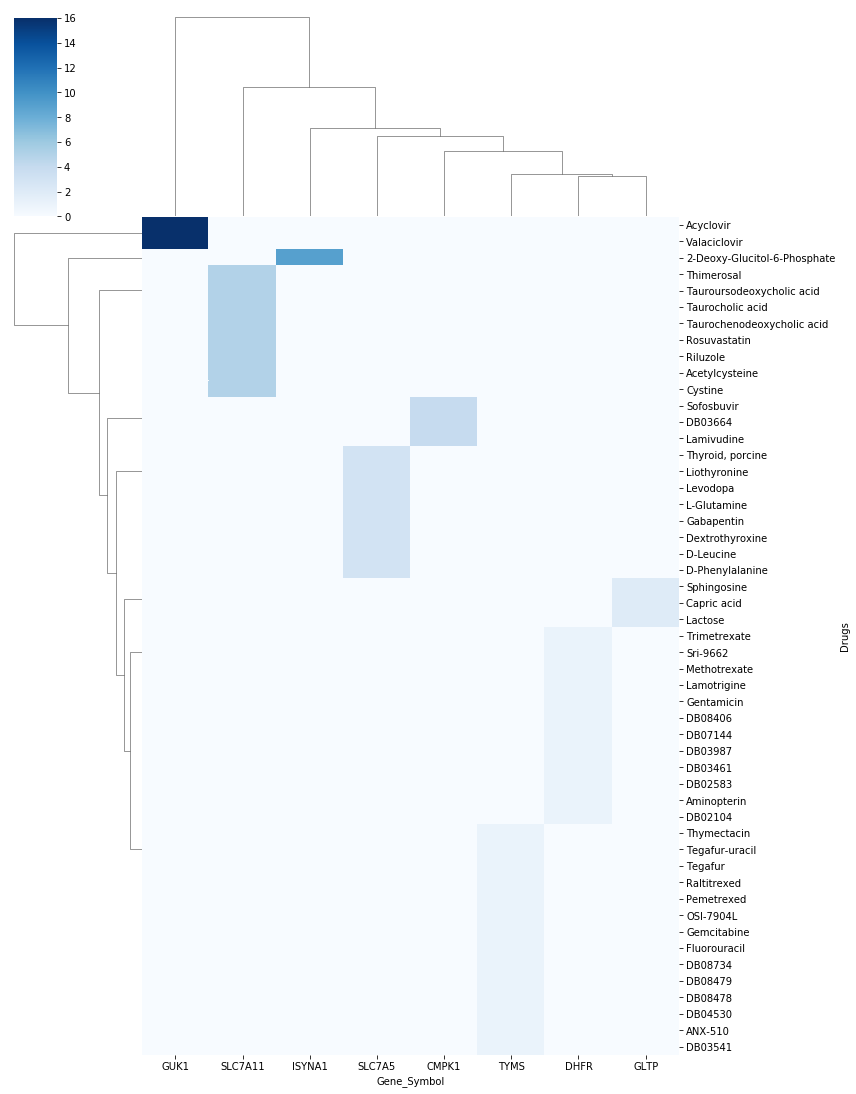

In [81]:
sko_db_drugs_hm =  sko_db_drugs.pivot_table(index='Drugs',columns = 'Gene_Symbol',values='Phenotype_Essentiality')
sko_db_drugs_hm = sko_db_drugs_hm.fillna(0)
plt.figure(figsize = (10,20))
ax = sns.clustermap(sko_db_drugs_hm.astype('int'),cmap='Blues',
                   col_cluster=True,row_cluster=True,mask=False,
                   #standard_scale=0,
                   yticklabels=True,
                   #square=True,
                   figsize=(12,(.3*(len(sko_db_drugs_hm.index)))))#,col_cluster=False,row_cluster=False)heatmap(enrich_coverage_all.iloc[:,4:], annot=True, linewidths=0.5)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [82]:
df_uniques = df.groupby('Drugs').agg({'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      #'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      #'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      'Drugs_Group': lambda x: list(x),'Drugs_Group': lambda x: list(x),
                                      'Phenotype_Safety': lambda x: list(x),'Phenotype_Safety': lambda x: np.mean(x),
                                      'Phenotype_Essentiality': lambda x: list(x),'Phenotype_Essentiality': lambda x: np.mean(x),
                                      #'GTEx_Safety': lambda x: list(x),'GTEx_Safety': lambda x: np.mean(x),
                                      #'GTEx_Safety_Class': lambda x: list(x),'GTEx_Safety_Class': lambda x: list(x),
                                      'side_effect_name': lambda x: list(x),'side_effect_name': lambda x: list(x),
                                      'Drugs_Categories': lambda x: list(x),'Drugs_Categories': lambda x: list(x)[0]
                                     })
df_uniques['Number_Genes'] = df_uniques['Gene_Symbol'].apply(lambda x: len(x))
#df_uniques['side_effect_name'] = df_uniques['side_effect_name'].apply(lambda x: np.unique(np.squeeze(x)).tolist())

df_uniques= df_uniques.sort_values(by=['Phenotype_Essentiality'],ascending=False)
df_uniques.to_csv('KO_data/SKO_db_Drugs_Unique.csv')
df_uniques.shape

(51, 7)

In [83]:
df_uniques.iloc[:,:].loc[:,['Gene_Symbol','Phenotype_Essentiality','Phenotype_Safety','Number_Genes']]

,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Number_Genes
Drugs,,,,
Valaciclovir,[GUK1],16.0,3.0,1
Acyclovir,[GUK1],16.0,3.0,1
2-Deoxy-Glucitol-6-Phosphate,[ISYNA1],9.0,1.0,1
Acetylcysteine,[SLC7A11],5.0,1.0,1
Cystine,[SLC7A11],5.0,1.0,1
Riluzole,[SLC7A11],5.0,1.0,1
Rosuvastatin,[SLC7A11],5.0,1.0,1
Thimerosal,[SLC7A11],5.0,1.0,1
Tauroursodeoxycholic acid,[SLC7A11],5.0,1.0,1


In [84]:
# Number of drugs with toxicity
df_uniques.loc[df_uniques.side_effect_name.astype('str').str.contains('toxicity'),:].shape

(14, 7)

In [85]:
df_uniques.shape

(51, 7)

In [86]:
# Classify drug categrories
drug_categories = df_uniques.Drugs_Categories.str.split('|').squeeze().tolist()
drug_categories = [x for x in drug_categories if str(x) !='nan']
drug_categories = np.concatenate(drug_categories)
drug_categories = pd.DataFrame(drug_categories)
drug_categories[0].value_counts().head(40)

Drugs that are Mainly Renally Excreted                            22
Antineoplastic Agents                                             21
Antimetabolites                                                   19
Immunosuppressive Agents                                          18
Enzyme Inhibitors                                                 17
Noxae                                                             17
Antineoplastic and Immunomodulating Agents                        17
Toxic Actions                                                     17
Nucleic Acid Synthesis Inhibitors                                 15
Heterocyclic Compounds, Fused-Ring                                15
Anti-Infective Agents                                             15
Folic Acid Antagonists                                            15
Myelosuppressive Agents                                           14
Cytochrome P-450 Substrates                                       14
Carbohydrates                     

In [87]:
#df_uniques.loc[df_uniques.index.str.contains('vir'),:]

In [88]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('anti-infective'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Valaciclovir,[GUK1],[approved],3.0,16.0,[nan],Acyclovir and prodrug|Anti-Infective Agents|An...,1
Acyclovir,[GUK1],[approved|investigational],3.0,16.0,[nan],"Acyclovir and prodrug|Amino Acids|Amino Acids,...",1
Rosuvastatin,[SLC7A11],[approved|investigational],1.0,5.0,[nan],"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",1
Tauroursodeoxycholic acid,[SLC7A11],[experimental|investigational],1.0,5.0,[nan],"Acids|Acids, Noncarboxylic|Alkanes|Alkanesulfo...",1
Taurochenodeoxycholic acid,[SLC7A11],[approved],1.0,5.0,[nan],Agents causing hyperkalemia|Agents that produc...,1
Sofosbuvir,[CMPK1],[approved],3.0,4.0,"[['Cardiotoxicity', 'Hepatotoxicity', 'Nephrop...",Anti-Infective Agents|Antimetabolites|Antineop...,1
Lamivudine,[CMPK1],[approved|investigational],3.0,4.0,[nan],Agents Causing Muscle Toxicity|Anti-HIV Agents...,1
DB03664,[CMPK1],[approved],3.0,4.0,[nan],Anti-Infective Agents|Antiinfectives for Syste...,1
DB02104,[DHFR],[approved],1.0,1.0,[nan],Amidines|Anti-Infective Agents|Antimalarials|A...,1


In [89]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Nucleoside'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Valaciclovir,[GUK1],[approved],3.0,16.0,[nan],Acyclovir and prodrug|Anti-Infective Agents|An...,1
Acyclovir,[GUK1],[approved|investigational],3.0,16.0,[nan],"Acyclovir and prodrug|Amino Acids|Amino Acids,...",1
Sofosbuvir,[CMPK1],[approved],3.0,4.0,"[['Cardiotoxicity', 'Hepatotoxicity', 'Nephrop...",Anti-Infective Agents|Antimetabolites|Antineop...,1
Lamivudine,[CMPK1],[approved|investigational],3.0,4.0,[nan],Agents Causing Muscle Toxicity|Anti-HIV Agents...,1
DB03664,[CMPK1],[approved],3.0,4.0,[nan],Anti-Infective Agents|Antiinfectives for Syste...,1
Thymectacin,[TYMS],[approved],1.0,1.0,[['Skin toxicity']],Antimetabolites|Antineoplastic Agents|Antineop...,1
Tegafur-uracil,[TYMS],[approved],1.0,1.0,"[['Cardiotoxicity', 'Hepatotoxicity', 'Nephrop...",Anti-Infective Agents|Antimetabolites|Antineop...,1
Tegafur,[TYMS],[approved|investigational],1.0,1.0,"[['Gastrointestinal toxicity', 'Hepatotoxicity...",Antimetabolites|Antineoplastic Agents|Antineop...,1
DB03541,[TYMS],[investigational],1.0,1.0,[nan],Carbohydrates|Deoxyribonucleosides|Deoxyuridin...,1


In [90]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('anticonvulsant'),:]

In [91]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('analgesics'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Taurochenodeoxycholic acid,[SLC7A11],[approved],1.0,5.0,[nan],Agents causing hyperkalemia|Agents that produc...,1
Gabapentin,[SLC7A5],[approved|investigational],1.0,3.0,[['Digitalis intoxication (NOS)']],"Acids, Acyclic|Agents causing angioedema|Amino...",1
L-Glutamine,[SLC7A5],[approved|investigational],1.0,3.0,[nan],"Acids, Acyclic|Acids, Carbocyclic|Amines|Amino...",1


In [92]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('steroid'),'Drugs_Categories'].values

In [93]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('antiviral'),['Gene_Symbol','Number_Genes']]

,Gene_Symbol,Number_Genes
Drugs,,
Valaciclovir,[GUK1],1
Acyclovir,[GUK1],1
Lamivudine,[CMPK1],1
DB03664,[CMPK1],1
Fluorouracil,[TYMS],1


In [94]:
df_uniques.shape

(51, 7)

In [95]:
drugs_immune =df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Immunosuppressive Agents'),:].index
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Immunosuppressive Agents'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Taurochenodeoxycholic acid,[SLC7A11],[approved],1.0,5.0,[nan],Agents causing hyperkalemia|Agents that produc...,1
Sofosbuvir,[CMPK1],[approved],3.0,4.0,"[['Cardiotoxicity', 'Hepatotoxicity', 'Nephrop...",Anti-Infective Agents|Antimetabolites|Antineop...,1
"Thyroid, porcine",[SLC7A5],[approved],1.0,3.0,[['Pulmonary toxicity']],Alkylating Activity|Alkylating Drugs|Amino Aci...,1
Gemcitabine,[TYMS],[approved|investigational],1.0,1.0,[nan],Antimetabolites|Antineoplastic Agents|Antineop...,1
DB04530,[TYMS],[approved],1.0,1.0,"[['CNS toxicity', 'Gastrointestinal toxicity',...","Abortifacient Agents|Abortifacient Agents, Non...",1
Thymectacin,[TYMS],[approved],1.0,1.0,[['Skin toxicity']],Antimetabolites|Antineoplastic Agents|Antineop...,1
Tegafur-uracil,[TYMS],[approved],1.0,1.0,"[['Cardiotoxicity', 'Hepatotoxicity', 'Nephrop...",Anti-Infective Agents|Antimetabolites|Antineop...,1
Tegafur,[TYMS],[approved|investigational],1.0,1.0,"[['Gastrointestinal toxicity', 'Hepatotoxicity...",Antimetabolites|Antineoplastic Agents|Antineop...,1
DB02583,[DHFR],[approved],1.0,1.0,"[['CNS toxicity', 'Gastrointestinal toxicity',...","Abortifacient Agents|Abortifacient Agents, Non...",1


In [96]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('antifungal agents'),:]

In [97]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('hyperkalemia'),:]

In [98]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('antibiotic'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Cystine,[SLC7A11],[investigational],1.0,5.0,[nan],"Amino Acids|Amino Acids, Peptides, and Protein...",1
DB03987,[DHFR],[approved|vet_approved],1.0,1.0,"[['Nephropathy toxic', 'Nephrotoxicity', 'Neur...",Agents that produce neuromuscular block (indir...,1
Gentamicin,[DHFR],[approved|investigational|vet_approved],1.0,1.0,[nan],Anti-Infective Agents|Antibiotics for Pneumocy...,1


In [99]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('cholestrol'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,


In [100]:
#drugs_antirh =df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Antirheumatic Agents'),:].index
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Antirheumatic Agents'),:]

In [101]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('lipid'),'Drugs_Categories'].values

In [102]:
df_uniques.loc[df_uniques.index.str.contains('statin'),'Drugs_Categories'].values

array(['Amino Acids|Amino Acids, Neutral|Amino Acids, Peptides, and Proteins|Amino Acids, Sulfur|Anti-Infective Agents|Antidote for Acetaminophen Overdose|Antidotes|Antioxidants|Compounds used in a research, industrial, or household setting|Cough and Cold Preparations|Cysteine|Decreased Respiratory Secretion Viscosity|Expectorants|Free Radical Scavengers|Increased Glutathione Concentration|OATP1B1/SLCO1B1 Inhibitors|Ophthalmologicals|Protective Agents|Reduction Activity|Respiratory System Agents|Sensory Organs|Sulfhydryl Compounds|Sulfur Compounds'],
      dtype=object)

In [103]:
df_uniques.loc[df_uniques.index.str.contains('sartan'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,


In [104]:
df_uniques.loc[df_uniques.index.str.contains('statin'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Rosuvastatin,[SLC7A11],[approved|investigational],1.0,5.0,[nan],"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",1


In [105]:
df_uniques.loc[df_uniques.index.str.endswith('pril'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,


In [106]:
#[x for x in drugs_immune  if x not in drugs_antirh]

In [107]:
## Find the coverage of 2 drug categories on differnt lung phenotypes
# Build an enrichmet table similar to 
db = df_uniques 
enrich = pd.DataFrame(columns = ['Term','Drugs','Genes','P-value','Overlap'],dtype='object')
terms =['Immunosuppressive','Antiviral','Antirheumatic','Hypolipidemic']#,'Anticonvulsant','Analgesic']#,'Antifungal']
enrich['Term'] = terms
enrich['P-value'] = 0

for i in range(len(terms)):
    x = db.Drugs_Categories.astype('str').str.lower().str.contains(terms[i].lower())
    #y = db.index.astype('str').str.lower().str.contains(terms[i].lower())
    #x = np.logical_or([x,y])
    genes = np.unique(np.concatenate(db.loc[x,'Gene_Symbol'])).tolist()
    enrich.loc[i,'Genes'] = ';'.join(genes)
    drugs = np.unique(db.loc[x,:].index).tolist()
    enrich.loc[i,'Drugs'] = ';'.join(drugs)
    # Total number of genes that has this term in drugbank
    x = drugbank_df.categories.astype('str').str.lower().str.contains(terms[i].lower())
    total_genes = np.unique(drugbank_df.loc[x,'entrez_gene_id']).tolist()
    enrich.loc[i,'Overlap'] = str(len(genes))+'/'+str(len(total_genes))

In [108]:
enrich.Drugs

0    ANX-510;DB02583;DB03461;DB04530;DB08406;DB0873...
1    Acyclovir;DB03664;Fluorouracil;Lamivudine;Vala...
2    DB02583;DB04530;DB08406;Pemetrexed;Taurochenod...
3                                       Acetylcysteine
Name: Drugs, dtype: object

In [109]:
enrich

,Term,Drugs,Genes,P-value,Overlap
0,Immunosuppressive,ANX-510;DB02583;DB03461;DB04530;DB08406;DB0873...,CMPK1;DHFR;SLC7A11;SLC7A5;TYMS,0,5/465
1,Antiviral,Acyclovir;DB03664;Fluorouracil;Lamivudine;Vala...,CMPK1;GUK1;TYMS,0,3/135
2,Antirheumatic,DB02583;DB04530;DB08406;Pemetrexed;Taurochenod...,DHFR;SLC7A11;TYMS,0,3/288
3,Hypolipidemic,Acetylcysteine,SLC7A11,0,1/144


In [110]:
#sko_summ = pd.read_csv('KO_data/SKO_Mapped_Unique.csv',index_col = 0)
#sko_summ.SKO_01_Toxic_Sym = sko_summ.SKO_01_Toxic_Sym.apply(lambda x:str(x).replace(' ','; ').replace("'",'').replace('[','').replace(']',''))
#sko_summ.SKO_01_Safe_Sym = sko_summ.SKO_01_Safe_Sym.apply(lambda x:str(x).replace(' ','; ').replace("'",'').replace('[','').replace(']',''))
#sko_summ['SKO_All'] = sko_summ.SKO_01_Toxic_Sym +'; '+ sko_summ.SKO_01_Safe_Sym
#sko_summ


enrich_coverage_all = Calculate_Enrichment_Coverage(enrich.iloc[:,[0,2,3,4]],sko_summ.iloc[:,:],'SKO_All')
plt.figure(figsize = (10,10))
ax = sns.heatmap(enrich_coverage_all.iloc[:,4:], annot=True, linewidths=0.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.savefig('Drug_Repurposing_Results_/SKO_Lung_Drugs_Classes_Enrichment.png', dpi=400,bbox_inches='tight')

enrich.loc[i,'Genes'] = ';'.join(genes)

enrich['#_Drugs'] = enrich['Drugs'].apply(lambda x: len(x.split(';')))
enrich.to_csv('Drug_Repurposing_Results_/SKO_Drugs_Classes.csv')
enrich

In [111]:
# Since none of the SKO drugs shares more than 1 gene per drug
df_uniques = df.groupby('Gene_Symbol').agg({'Drugs': lambda x: list(x),'Drugs': lambda x: list(x),
                                      #'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      #'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      #'Drugs_Group': lambda x: list(x),'Drugs_Group': lambda x: list(x),
                                      'Phenotype_Safety': lambda x: list(x),'Phenotype_Safety': lambda x: np.mean(x),
                                      'Phenotype_Essentiality': lambda x: list(x),'Phenotype_Essentiality': lambda x: np.mean(x),
                                      #'GTEx_Safety': lambda x: list(x),'GTEx_Safety': lambda x: np.mean(x),
                                      #'GTEx_Safety_Class': lambda x: list(x),'GTEx_Safety_Class': lambda x: list(x),
                                      #'side_effect_name': lambda x: list(x),'side_effect_name': lambda x: list(x),
                                      #'Drugs_Categories': lambda x: list(x),'Drugs_Categories': lambda x: list(x)[0]
                                     })
#df_uniques['Number_Genes'] = df_uniques['Gene_Symbol'].apply(lambda x: len(x))
#df_uniques['side_effect_name'] = df_uniques['side_effect_name'].apply(lambda x: np.unique(np.squeeze(x)).tolist())

df_uniques= df_uniques.sort_values(by=['Phenotype_Essentiality'],ascending=False)
df_uniques.to_csv('KO_data/SKO_db_Drugs_Unique_per_gene.csv')
df_uniques

,Drugs,Phenotype_Safety,Phenotype_Essentiality
Gene_Symbol,,,
GUK1,"[Acyclovir, Valaciclovir]",3.0,16.0
ISYNA1,[2-Deoxy-Glucitol-6-Phosphate],1.0,9.0
SLC7A11,"[Riluzole, Taurochenodeoxycholic acid, Acetylc...",1.0,5.0
CMPK1,"[Sofosbuvir, Lamivudine, DB03664]",3.0,4.0
SLC7A5,"[Gabapentin, D-Leucine, Dextrothyroxine, Lioth...",1.0,3.0
GLTP,"[Lactose, Capric acid, Sphingosine]",1.0,2.0
DHFR,"[Gentamicin, Trimetrexate, DB08406, DB02583, D...",1.0,1.0
TYMS,"[Raltitrexed, Thymectacin, Fluorouracil, Tegaf...",1.0,1.0


### Drug Repurposing in DKO

In [112]:
# Drug Repurposing
drugbank_df  =pd.read_csv('./DrugBank_Drug_Target_Toxicity_Only_Indication.csv',sep=',',index_col=0)
#drugbank_df = drugbank_df[~drugbank_df.groups.str.contains('withdrawn')]
#drugbank_df = drugbank_df.loc[drugbank_df.groups != 'experimental',:]
#drugbank_df = drugbank_df.drop(columns = ['drugbank_id.1'])

# Replace drug name for large name by drug id
drugbank_df.loc[drugbank_df.name.apply(lambda x:len(x))>40,'name'] =drugbank_df.loc[drugbank_df.name.apply(lambda x:len(x))>40,'drugbank_id']
drugbank_df.head(3)

,drugbank_id,category,uniprot_id,entrez_gene_id,organism,known_action,actions,pubmed_ids,name,type,groups,atc_codes,categories,description,hgnc_symbol,umls_cui_from_meddra,side_effect_name,Meddra_Indication
0,DB00001,target,P00734,2147,Humans,yes,inhibitor,NaN,Lepirudin,biotech,approved,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",Lepirudin is identical to natural hirudin exce...,RET,NaN,NaN,NaN
1,DB00006,target,P00734,2147,Humans,yes,inhibitor,NaN,Bivalirudin,small molecule,approved|investigational,B01AE06,"Amino Acids, Peptides, and Proteins|Anticoagul...",Bivalirudin is a synthetic 20 residue peptide ...,RET,NaN,NaN,NaN
2,DB00025,enzyme,P00734,2147,Humans,unknown,activator,NaN,"Antihemophilic factor, human recombinant",biotech,approved|investigational,B02BD02,"Amino Acids, Peptides, and Proteins|Biological...",Human recombinant antihemophilic factor (AHF) ...,RET,NaN,NaN,NaN


In [113]:
# Since the same drug different approval groups on different entries, we will unify them by concatenating
drugbank_drugs = np.unique(drugbank_df.name)
for drug in drugbank_drugs:
    drugbank_df.loc[drugbank_df.name ==drug,'groups'] = '|'.join(np.unique(drugbank_df.loc[drugbank_df.name ==drug,'groups']).tolist())

In [114]:
#drugbank_df.loc[drugbank_df.name =='Fosinopril',:]

In [115]:
#drugbank_df.loc[drugbank_df.name =='Cloxacillin',:]

In [116]:
#drugbank_df.loc[drugbank_df.name =='Gemcitabine',:]

In [117]:
gtex_db  = pd.read_csv('KO_data/DKO_Lung_Studies_Summary.csv',index_col=0)

In [118]:
gtex_db.shape

(598, 8)

In [119]:
gtex_db.head()

,Gene1,Gene2,Series,RECON,Experiment_Freq,Safety_Ratio,Gene1_Symbol,Gene2_Symbol
0,54675,11212,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['2', '3', '2', '3', '2', '3', '2', '3', '2', ...",14,10,CRLS1,PLPBP
1,259230,11212,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['2', '3', '2', '2', '3', '2', '3', '2', '3', ...",14,9,SGMS1,PLPBP
2,6240,50484,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",14,0,RRM1,RRM2B
3,50484,6241,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",14,0,RRM2B,RRM2
4,60386,1841,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",13,0,SLC25A19,DTYMK


In [125]:
gtex_db.RECON[0]

"['2', '3', '2', '3', '2', '3', '2', '3', '2', '3', '2', '2', '3', '2', '3', '2', '3', '2', '3', '2', '2', '3', '2', '2', '3']"

In [126]:
#gtex_db = dko_db #pd.concat([dko_db_safe,dko_db_some_toxic])
df = pd.DataFrame(np.zeros((15000,len(gtex_db.columns))),columns = gtex_db.columns)
df['Drugs_1']= 0
df['groups_1'] = 0
df['Drugs_2']= 0
df['groups_2'] = 0
drugbank_genes = drugbank_df.entrez_gene_id
df = df.astype('object')
k = 0
genes_1 =  gtex_db.iloc[:,0].unique().tolist()
for i in range(len(genes_1)):
    gene = genes_1[i]
    if int(gene) in drugbank_df.entrez_gene_id.tolist():
        genes_2 = gtex_db.loc[gtex_db.Gene1==gene,'Gene2']
        genes_2 = [int(x) for x in genes_2 if int(x) in drugbank_genes]

        drugs_1 = list(set(drugbank_df.loc[drugbank_genes==int(gene),'name']))
        drugs_2 = drugbank_df.loc[drugbank_genes.isin(genes_2),'name'].tolist()
        groups_2 = drugbank_df.loc[drugbank_genes.isin(genes_2),'groups'].tolist()

        genes_2_ext = drugbank_df.loc[drugbank_genes.isin(genes_2),'entrez_gene_id'].tolist()

        for l in range(len(drugs_1)):
            df.loc[k:k + len(genes_2_ext)-1,'Gene1'] = int(gene)
            #df.iloc[k+ len(genes_2_ext),1:] = gtex_db.iloc[i,1:]

            df.loc[k:k+ len(genes_2_ext)-1,'Drugs_1'] = drugs_1[l]
            df.loc[k:k+ len(genes_2_ext)-1,'groups_1'] = list(drugbank_df.loc[drugbank_df.name==drugs_1[l],'groups'])[0]

            df.loc[k:k + len(genes_2_ext)-1,'Gene2'] = genes_2_ext
            df.loc[k:k + len(genes_2_ext)-1,'Drugs_2'] = drugs_2
            df.loc[k:k + len(genes_2_ext)-1,'groups_2'] = groups_2

            k = k +len(genes_2_ext) 
    else:
        pass

#df = df.loc[df.Drugs_1!=0,:]
#df.to_csv('Drug_Repurposing_Results/GTEx_SKO_Safe_Drugs.csv')

In [127]:
df.Gene1 = df.Gene1.astype('int') 
df.Gene2 = df.Gene2.astype('int')
gtex_db.Gene1 = gtex_db.Gene1.astype('int') 
gtex_db.Gene2 = gtex_db.Gene2.astype('int')

In [128]:
# Mapping the gene symbol and essentiality
for i in range(gtex_db.shape[0]):
    gene1 = int(gtex_db.loc[i,'Gene1'])
    gene2 = int(gtex_db.loc[i,'Gene2'])
    cols = ['Series','RECON','Experiment_Freq','Safety_Ratio','Gene1_Symbol','Gene2_Symbol']
    df.loc[np.logical_and(df.Gene1==gene1,df.Gene2==gene2),cols] = gtex_db.loc[np.logical_and(gtex_db.Gene1 ==gene1,gtex_db.Gene2==gene2),cols].values

In [129]:
df.head(5)

,Gene1,Gene2,Series,RECON,Experiment_Freq,Safety_Ratio,Gene1_Symbol,Gene2_Symbol,Drugs_1,groups_1,Drugs_2,groups_2
0,6240,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '2', '3', '2', '3', '2', '3']",5,0,RRM1,GUK1,Clofarabine,approved|investigational,Valaciclovir,approved|investigational
1,6240,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '2', '3', '2', '3', '2', '3']",5,0,RRM1,GUK1,Clofarabine,approved|investigational,Acyclovir,approved
2,6240,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '2', '3', '2', '3', '2', '3']",5,0,RRM1,GUK1,Clofarabine,approved|investigational,Guanosine-5'-Monophosphate,experimental
3,6240,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '2', '3', '2', '3', '2', '3']",5,0,RRM1,GUK1,Tezacitabine,investigational,Valaciclovir,approved|investigational
4,6240,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '2', '3', '2', '3', '2', '3']",5,0,RRM1,GUK1,Tezacitabine,investigational,Acyclovir,approved


In [133]:
df.shape

(11197, 12)

In [131]:
df = df.loc[df.Drugs_1!=0,:]

In [132]:
df.tail(5)

,Gene1,Gene2,Series,RECON,Experiment_Freq,Safety_Ratio,Gene1_Symbol,Gene2_Symbol,Drugs_1,groups_1,Drugs_2,groups_2
11192,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Adapalene,approved,DB02783,experimental
11193,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Cysteine,approved|nutraceutical,Pyridoxal phosphate,approved|investigational|nutraceutical
11194,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Cysteine,approved|nutraceutical,Aspartic acid,approved|nutraceutical
11195,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Cysteine,approved|nutraceutical,Glutamic acid,approved|nutraceutical
11196,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Cysteine,approved|nutraceutical,DB02783,experimental


In [229]:
dko_summ = df.loc[:,['Gene1_Symbol','Gene2_Symbol','Drugs_1','Drugs_2','groups_1','groups_2','Experiment_Freq','Safety_Ratio']]
dko_summ.columns = ['Gene1_Symbol', 'Gene2_Symbol', 'Drugs_1', 'Drugs_2', 'Drugs_Group_1', 'Drugs_Group_2','Phenotype_Essentiality','Phenotype_Safety']

In [230]:
dko_summ.head()

,Gene1_Symbol,Gene2_Symbol,Drugs_1,Drugs_2,Drugs_Group_1,Drugs_Group_2,Phenotype_Essentiality,Phenotype_Safety
0,RRM1,GUK1,Clofarabine,Valaciclovir,approved|investigational,approved|investigational,5,0
1,RRM1,GUK1,Clofarabine,Acyclovir,approved|investigational,approved,5,0
2,RRM1,GUK1,Clofarabine,Guanosine-5'-Monophosphate,approved|investigational,experimental,5,0
3,RRM1,GUK1,Tezacitabine,Valaciclovir,investigational,approved|investigational,5,0
4,RRM1,GUK1,Tezacitabine,Acyclovir,investigational,approved,5,0


In [231]:
# Number of drugable gene pairs
dko_summ.loc[:,['Gene1_Symbol','Gene2_Symbol']].drop_duplicates().shape

(137, 2)

In [232]:
dko_summ.shape

(11197, 8)

In [233]:
df.groups_1.value_counts()

approved                                               3306
approved|investigational                               2812
experimental                                           2024
approved|vet_approved                                   668
approved|investigational|vet_approved                   394
approved|investigational|nutraceutical                  372
approved|nutraceutical                                  319
experimental|investigational                            250
investigational                                         232
approved|investigational|withdrawn                      187
approved|vet_approved|withdrawn                         113
approved|experimental                                    98
approved|illicit|investigational                         66
investigational|nutraceutical                            66
approved|investigational|nutraceutical|vet_approved      66
approved|illicit                                         66
approved|nutraceutical|vet_approved     

In [234]:
df.groups_2.value_counts()

experimental                                           3605
approved                                               2449
approved|investigational                               2337
approved|vet_approved                                   495
investigational                                         458
approved|nutraceutical                                  402
approved|investigational|nutraceutical                  361
approved|investigational|vet_approved                   338
investigational|nutraceutical                           117
experimental|investigational                            106
nutraceutical                                            94
approved|investigational|withdrawn                       87
approved|nutraceutical|vet_approved                      84
approved|vet_approved|withdrawn                          67
investigational|withdrawn                                64
approved|investigational|nutraceutical|vet_approved      43
approved|illicit|investigational        

In [235]:
dko_summ.shape

(11197, 8)

In [236]:
dko_summ = dko_summ.drop_duplicates()

In [237]:
dko_summ.shape

(10683, 8)

In [238]:
# One drug for target pair
#dko_summ.loc[dko_summ.Drugs_1==dko_summ.Drugs_2,:].to_csv('Drug_Repurposing_Results_/DKO_Drugs_OneDrug.csv')
#dko_summ.loc[dko_summ.Drugs_1==dko_summ.Drugs_2,:].head(50)

In [239]:
#dko_summ.loc[dko_summ.Drugs_1==dko_summ.Drugs_2,:].tail(20)

In [240]:
# Filter by drug groups

dko_summ = dko_summ[~dko_summ.Drugs_Group_1.str.contains('withdrawn')]
#dko_summ = dko_summ.loc[dko_summ.Drugs_Group_1 != 'experimental',:]
dko_summ = dko_summ.loc[~dko_summ.Drugs_Group_1.str.contains('nutraceutical'),:]
dko_summ = dko_summ.loc[~dko_summ.Drugs_1.isin(['Ethanol','NADH','Succinic acid']),:]

#dko_summ = dko_summ.loc[~dko_summ.Drugs_Group_1.str.contains( 'nutraceutical'),:]

#dko_summ = dko_summ.loc[dko_summ.Drugs_Group_1 != 'withdrawn',:]
dko_summ = dko_summ[~dko_summ.Drugs_Group_2.str.contains('withdrawn')]
#dko_summ = dko_summ.loc[dko_summ.Drugs_Group_2 != 'experimental',:]
dko_summ = dko_summ.loc[~dko_summ.Drugs_Group_1.str.contains('nutraceutical'),:]
dko_summ = dko_summ.loc[~dko_summ.Drugs_2.isin(['Ethanol','NADH','Succinic acid']),:]

#dko_summ = dko_summ.loc[~dko_summ.Drugs_Group_2.str.contains('nutraceutical'),:]

#dko_summ = dko_summ.loc[dko_summ.Drugs_Group_2 != 'withdrawn',:]


In [241]:
#dko_summ.loc[dko_summ.Drugs_2 =='Gemcitabine',:]

In [242]:
#dko_summ.loc[dko_summ.Drugs_2 =='Fosinopril',:]

In [243]:
dko_summ.shape

(9055, 8)

In [244]:
#dko_summ = dko_summ.loc[dko_summ.Phenotype_Essentiality>2,:]

In [245]:
dko_summ.shape

(9055, 8)

In [246]:
dko_summ.head(20)

,Gene1_Symbol,Gene2_Symbol,Drugs_1,Drugs_2,Drugs_Group_1,Drugs_Group_2,Phenotype_Essentiality,Phenotype_Safety
0,RRM1,GUK1,Clofarabine,Valaciclovir,approved|investigational,approved|investigational,5,0
1,RRM1,GUK1,Clofarabine,Acyclovir,approved|investigational,approved,5,0
2,RRM1,GUK1,Clofarabine,Guanosine-5'-Monophosphate,approved|investigational,experimental,5,0
3,RRM1,GUK1,Tezacitabine,Valaciclovir,investigational,approved|investigational,5,0
4,RRM1,GUK1,Tezacitabine,Acyclovir,investigational,approved,5,0
5,RRM1,GUK1,Tezacitabine,Guanosine-5'-Monophosphate,investigational,experimental,5,0
6,RRM1,GUK1,Gemcitabine,Valaciclovir,approved,approved|investigational,5,0
7,RRM1,GUK1,Gemcitabine,Acyclovir,approved,approved,5,0
8,RRM1,GUK1,Gemcitabine,Guanosine-5'-Monophosphate,approved,experimental,5,0
9,RRM1,GUK1,Fludarabine,Valaciclovir,approved,approved|investigational,5,0


In [247]:
# Safe drug pairs
#dko_summ.loc[dko_summ.DKO_Toxicity=='Safe',:].head(20)

#*** DKO drug pairs with agonist in any
idx = np.logical_or(dko_summ.MOA_1.isin(['inducer','activator','agonist','stimulator']),dko_summ.MOA_2.isin(['inducer','activator','agonist','stimulator']))
dko_summ_inducer = dko_summ.loc[idx,:]
#dko_summ_inducer = dko_summ_inducer.loc[dko_summ_inducer.MOA_2.isin(['inducer','activator','agonist']),:]

In [248]:
#dko_summ_inducer.head()

In [249]:
dko_summ['Gene_Pair'] = dko_summ.Gene1_Symbol.astype('str')+';'+dko_summ.Gene2_Symbol.astype('str')
dko_summ['Drug_Pair'] = dko_summ.Drugs_1.astype('str')+';'+dko_summ.Drugs_2.astype('str')


In [250]:
dko_summ

,Gene1_Symbol,Gene2_Symbol,Drugs_1,Drugs_2,Drugs_Group_1,Drugs_Group_2,Phenotype_Essentiality,Phenotype_Safety,Gene_Pair,Drug_Pair
0,RRM1,GUK1,Clofarabine,Valaciclovir,approved|investigational,approved|investigational,5,0,RRM1;GUK1,Clofarabine;Valaciclovir
1,RRM1,GUK1,Clofarabine,Acyclovir,approved|investigational,approved,5,0,RRM1;GUK1,Clofarabine;Acyclovir
2,RRM1,GUK1,Clofarabine,Guanosine-5'-Monophosphate,approved|investigational,experimental,5,0,RRM1;GUK1,Clofarabine;Guanosine-5'-Monophosphate
3,RRM1,GUK1,Tezacitabine,Valaciclovir,investigational,approved|investigational,5,0,RRM1;GUK1,Tezacitabine;Valaciclovir
4,RRM1,GUK1,Tezacitabine,Acyclovir,investigational,approved,5,0,RRM1;GUK1,Tezacitabine;Acyclovir
...,...,...,...,...,...,...,...,...,...,...
11188,GOT1,GOT2,Copper,DB02783,approved|investigational,experimental,1,0,GOT1;GOT2,Copper;DB02783
11189,GOT1,GOT2,Adapalene,Pyridoxal phosphate,approved,approved|investigational|nutraceutical,1,0,GOT1;GOT2,Adapalene;Pyridoxal phosphate
11190,GOT1,GOT2,Adapalene,Aspartic acid,approved,approved|nutraceutical,1,0,GOT1;GOT2,Adapalene;Aspartic acid
11191,GOT1,GOT2,Adapalene,Glutamic acid,approved,approved|nutraceutical,1,0,GOT1;GOT2,Adapalene;Glutamic acid


In [251]:
# Change dublicated drug pairs with a unifed name pairs
for i in range(dko_summ.shape[0]):
    drug1 = dko_summ.iloc[i,2]
    drug2 = dko_summ.iloc[i,3]
    for k in range(i+1,dko_summ.shape[0],1):
        if drug1 == dko_summ.iloc[k,3] and drug2 == dko_summ.iloc[k,2]:
            dko_summ.iloc[k,9] = dko_summ.iloc[i,9]
        else:
            pass

In [252]:
df_uniques = dko_summ.groupby('Drug_Pair').agg({'Gene_Pair': lambda x: set(x),'Gene_Pair': lambda x: set(x),
                                     'Phenotype_Essentiality': lambda x: list(x),'Phenotype_Essentiality': lambda x: np.mean(x),
                                          'Phenotype_Safety': lambda x: list(x),'Phenotype_Safety': lambda x: np.mean(x)
                                         })
df_uniques['Number_Genes'] = df_uniques['Gene_Pair'].apply(lambda x: len(x))
df_uniques= df_uniques.sort_values(by=['Number_Genes'],ascending=False)
df_uniques['Drugs1'] =  pd.Series({x: x.split(';')[0] for x in df_uniques.index})
df_uniques['Drugs2'] =  pd.Series({x: x.split(';')[1] for x in df_uniques.index})
df_uniques.to_csv('KO_data/DKO_Drug_Repurposing_Unique.csv')
df_uniques.shape

(7601, 6)

In [253]:
df_uniques.sort_values(by=['Number_Genes'],ascending=False)

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Mercaptopurine;Pemetrexed,"{TYMS;SLC29A2, SLC29A2;SLC29A1, DHFR;SLC29A2, ...",2.60,0.4,5,Mercaptopurine,Pemetrexed
Azathioprine;Pemetrexed,"{TYMS;SLC29A2, SLC29A2;SLC29A1, DHFR;SLC29A2, ...",2.60,0.4,5,Azathioprine,Pemetrexed
Trifluridine;Pemetrexed,"{TYMP;DHFR, TYMS;SLC29A2, SLC29A2;SLC29A1, TYM...",1.00,0.8,5,Trifluridine,Pemetrexed
Cladribine;Acyclovir,"{RRM2B;GUK1, RRM2;GUK1, PNP;GUK1, RRM1;GUK1}",4.75,0.0,4,Cladribine,Acyclovir
Tetrafluoroaluminate Ion;Ubiquinone Q1,"{CMPK1;SDHA, CMPK1;SDHD, CMPK1;SDHB, CMPK1;SDHC}",1.00,1.0,4,Tetrafluoroaluminate Ion,Ubiquinone Q1
...,...,...,...,...,...,...
Uridine;Thymidine monophosphate,{SLC29A1;DTYMK},2.00,1.0,1,Uridine,Thymidine monophosphate
Uridine;Zidovudine monophosphate,{SLC29A1;DTYMK},2.00,1.0,1,Uridine,Zidovudine monophosphate
Ursodeoxycholic acid;Cysteine,{SLCO1A2;CTH},1.00,0.0,1,Ursodeoxycholic acid,Cysteine


In [254]:
df_uniques.head(20)

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Mercaptopurine;Pemetrexed,"{TYMS;SLC29A2, SLC29A2;SLC29A1, DHFR;SLC29A2, ...",2.60,0.4,5,Mercaptopurine,Pemetrexed
Trifluridine;Pemetrexed,"{TYMP;DHFR, TYMS;SLC29A2, SLC29A2;SLC29A1, TYM...",1.00,0.8,5,Trifluridine,Pemetrexed
Azathioprine;Pemetrexed,"{TYMS;SLC29A2, SLC29A2;SLC29A1, DHFR;SLC29A2, ...",2.60,0.4,5,Azathioprine,Pemetrexed
Uridine-5'-Diphosphate;DB04141,"{CMPK1;SDHA, CMPK1;SDHD, CMPK1;SDHB, CMPK1;SDHC}",1.00,1.0,4,Uridine-5'-Diphosphate,DB04141
Cladribine;Guanosine-5'-Monophosphate,"{RRM2B;GUK1, RRM2;GUK1, PNP;GUK1, RRM1;GUK1}",4.75,0.0,4,Cladribine,Guanosine-5'-Monophosphate
Gemcitabine;Ubiquinone Q1,"{CMPK1;SDHA, CMPK1;SDHD, CMPK1;SDHB, CMPK1;SDHC}",1.00,1.0,4,Gemcitabine,Ubiquinone Q1
Uridine-5'-Diphosphate;Ubiquinone Q1,"{CMPK1;SDHA, CMPK1;SDHD, CMPK1;SDHB, CMPK1;SDHC}",1.00,1.0,4,Uridine-5'-Diphosphate,Ubiquinone Q1
Cytidine-5'-Monophosphate;Ubiquinone Q1,"{CMPK1;SDHA, CMPK1;SDHD, CMPK1;SDHB, CMPK1;SDHC}",1.00,1.0,4,Cytidine-5'-Monophosphate,Ubiquinone Q1
Methotrexate;Trifluridine,"{DHFR;SLC29A2, TYMP;DHFR, TYMS;SLC29A2, TYMS;T...",1.00,0.5,4,Methotrexate,Trifluridine


In [255]:
# One drug for target pair
dko_one_drug = df_uniques.loc[df_uniques.Drugs1==df_uniques.Drugs2,:]
#dko_one_drug.to_csv('Drug_Repurposing_Results_/DKO_Drugs_OneDrug.csv')
dko_one_drug.shape

(50, 6)

In [256]:
dko_one_drug

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Trifluridine;Trifluridine,"{TYMS;TYMP, TYMS;SLC29A2, SLC29A2;SLC29A1}",1.0,1.0,3,Trifluridine,Trifluridine
Mercaptopurine;Mercaptopurine,"{HPRT1;PPAT, SLC29A2;SLC29A1}",3.0,1.0,2,Mercaptopurine,Mercaptopurine
Gemcitabine;Gemcitabine,"{TYMS;SLC29A2, SLC29A2;SLC29A1}",1.0,1.0,2,Gemcitabine,Gemcitabine
Tegafur-uracil;Tegafur-uracil,"{TYMS;SLC29A2, SLC29A2;SLC29A1}",1.0,1.0,2,Tegafur-uracil,Tegafur-uracil
Lisinopril;Lisinopril,{SLC15A1;SLC15A2},12.0,0.0,1,Lisinopril,Lisinopril
Nateglinide;Nateglinide,{SLC15A1;SLC15A2},12.0,0.0,1,Nateglinide,Nateglinide
Moexipril;Moexipril,{SLC15A1;SLC15A2},12.0,0.0,1,Moexipril,Moexipril
Glyburide;Glyburide,{SLC15A1;SLC15A2},12.0,0.0,1,Glyburide,Glyburide
Tolbutamide;Tolbutamide,{SLC15A1;SLC15A2},12.0,0.0,1,Tolbutamide,Tolbutamide


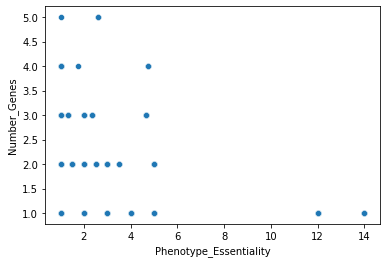

In [257]:
sns.scatterplot(df_uniques['Phenotype_Essentiality'],df_uniques['Number_Genes'])

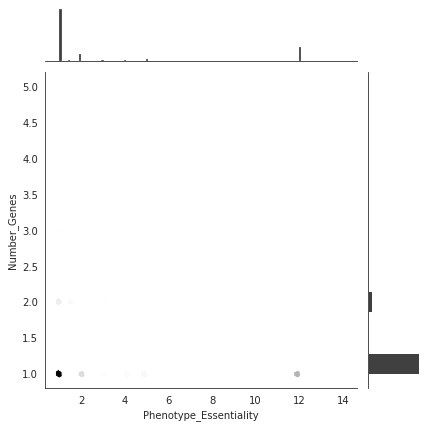

In [258]:
x, y = df_uniques['Phenotype_Essentiality'],df_uniques['Number_Genes']
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, kind="hex", color="k");
    

In [259]:
#df_uniques['Duplicated_drugs'] = 0

In [260]:
#df_uniques.shape

In [261]:
#df_uniques.Phenotype_Essentiality.hist()

In [262]:
#df_uniques.Number_Genes.hist()

In [263]:
df_uniques= df_uniques.sort_values(by=['Phenotype_Essentiality'],ascending=False)

df_uniques.head(20)

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Cladribine;Cladribine,{RRM2B;RRM2},14.0,0.0,1,Cladribine,Cladribine
Cladribine;GTI 2040,{RRM2B;RRM2},14.0,0.0,1,Cladribine,GTI 2040
Cladribine;Motexafin gadolinium,{RRM2B;RRM2},14.0,0.0,1,Cladribine,Motexafin gadolinium
Cladribine;Imexon,{RRM2B;RRM2},14.0,0.0,1,Cladribine,Imexon
Cladribine;Gallium nitrate,{RRM2B;RRM2},14.0,0.0,1,Cladribine,Gallium nitrate
Benzylpenicillin;Tranexamic acid,{SLC15A1;SLC15A2},12.0,0.0,1,Benzylpenicillin,Tranexamic acid
Benzylpenicillin;Ubenimex,{SLC15A1;SLC15A2},12.0,0.0,1,Benzylpenicillin,Ubenimex
Benzylpenicillin;Valaciclovir,{SLC15A1;SLC15A2},12.0,0.0,1,Benzylpenicillin,Valaciclovir
Benzylpenicillin;Oxacillin,{SLC15A1;SLC15A2},12.0,0.0,1,Benzylpenicillin,Oxacillin


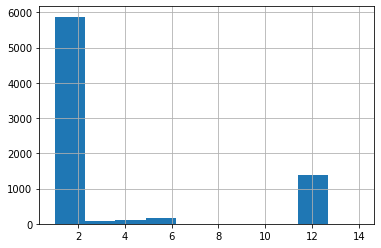

In [264]:
df_uniques.Phenotype_Essentiality.hist()

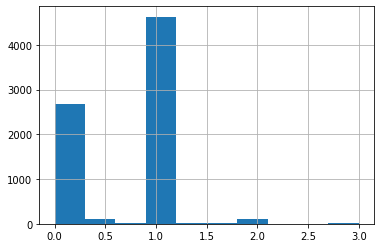

In [265]:
df_uniques.Phenotype_Safety.hist()

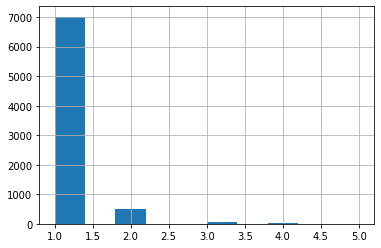

In [266]:
df_uniques.Number_Genes.hist()

In [267]:
# Filtering by essentiality and safety
#df_uniques = df_uniques.loc[df_uniques.Phenotype_Essentiality>1,:]
#df_uniques = df_uniques.loc[df_uniques.Phenotype_Safety>=1,:]

In [268]:
# Filtering by essentiality and safety and number of gene-pairs

import functools
df_reduced = df_uniques.loc[functools.reduce(np.logical_and,(df_uniques.Phenotype_Essentiality>1,df_uniques.Number_Genes>1,df_uniques.Phenotype_Safety>1)),:]

In [323]:
df_reduced2 = df_uniques.loc[functools.reduce(np.logical_and,(df_uniques.Phenotype_Essentiality>1,df_uniques.Number_Genes>0.2,df_uniques.Phenotype_Safety>1)),:]

In [324]:
idx = np.logical_and(df_uniques.Phenotype_Essentiality>1,df_uniques.Phenotype_Safety>1)
df_reduced = df_uniques.loc[idx,:]

In [325]:
df_reduced.shape

(64, 6)

In [326]:
df_reduced2.shape

(64, 6)

In [327]:
df_reduced.sort_values(by=['Number_Genes'],ascending=False).head()

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Gemcitabine;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT, TYMS;PLPBP}",1.333333,1.333333,3,Gemcitabine,Pyridoxal phosphate
Rosuvastatin;Cysteine,"{SLC7A11;CBS, SLCO1A2;CTH}",3.000000,1.500000,2,Rosuvastatin,Cysteine
Lamivudine;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Lamivudine,Pyridoxal phosphate
Tetrafluoroaluminate Ion;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Tetrafluoroaluminate Ion,Pyridoxal phosphate
Cytidine-5'-Monophosphate;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Cytidine-5'-Monophosphate,Pyridoxal phosphate


In [328]:
df_reduced2.sort_values(by=['Number_Genes'],ascending=False).head()

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Gemcitabine;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT, TYMS;PLPBP}",1.333333,1.333333,3,Gemcitabine,Pyridoxal phosphate
Rosuvastatin;Cysteine,"{SLC7A11;CBS, SLCO1A2;CTH}",3.000000,1.500000,2,Rosuvastatin,Cysteine
Lamivudine;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Lamivudine,Pyridoxal phosphate
Tetrafluoroaluminate Ion;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Tetrafluoroaluminate Ion,Pyridoxal phosphate
Cytidine-5'-Monophosphate;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Cytidine-5'-Monophosphate,Pyridoxal phosphate


In [329]:
df_reduced2.tail()

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
DB03664;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,DB03664,Pyridoxal phosphate
Cytidine-5'-Monophosphate;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Cytidine-5'-Monophosphate,Pyridoxal phosphate
Tetrafluoroaluminate Ion;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Tetrafluoroaluminate Ion,Pyridoxal phosphate
Lamivudine;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Lamivudine,Pyridoxal phosphate
Gemcitabine;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT, TYMS;PLPBP}",1.333333,1.333333,3,Gemcitabine,Pyridoxal phosphate


In [330]:
import math


In [ ]:
dko_one_drug  = dko_one_drug.loc[:,['Drugs1','Gene_Pair','Phenotype_Essentiality','Phenotype_Safety','Number_Genes']]
dko_one_drug.columns = ['Drug','Gene_Pair','Phenotype_Essentiality','Phenotype_Safety','Number_Genes']
dko_one_drug['Phenotype_Essentiality'] = dko_one_drug['Phenotype_Essentiality'].apply(lambda x: math.floor(x * 100)/100.0)
dko_one_drug['Phenotype_Safety'] = dko_one_drug['Phenotype_Safety'].apply(lambda x: math.floor(x * 100)/100.0)

dko_one_drug['Number_Genes']=dko_one_drug['Number_Genes'].astype('int')

In [317]:
dko_one_drug = dko_one_drug.sort_values(by=['Number_Genes','Phenotype_Essentiality'],ascending=False)
dko_one_drug.reset_index(inplace=True,drop=True)
dko_one_drug.to_csv('KO_data/DKO_Drugs_OneDrug.csv')


In [318]:
df_uniques.to_csv('KO_data/DKO_Drug_Repurposing_Unique.csv')


In [332]:
all_dko_drugs = df_reduced.index.tolist()
all_dko_drugs = np.unique(np.concatenate([str(x).split(';') for x in all_dko_drugs]))
dko_cor_1 = pd.DataFrame(columns =all_dko_drugs, index = all_dko_drugs )
dko_cor_2 = pd.DataFrame(columns =all_dko_drugs, index = all_dko_drugs )
dko_cor_3 = pd.DataFrame(columns =all_dko_drugs, index = all_dko_drugs )
dko_cor_1 = dko_cor_1.fillna(0)
for x in range(df_reduced.shape[0]):
    drug1, drug2 = df_reduced.index[x].split(';')
    dko_cor_1.loc[drug1,drug2] = df_reduced.iloc[x,1]
        

In [333]:
len(all_dko_drugs)

23

<Figure size 1440x1440 with 0 Axes>

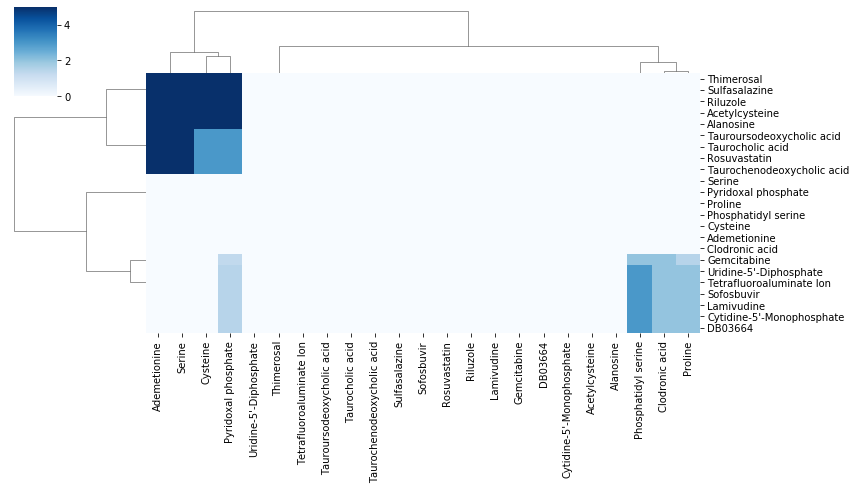

In [334]:
plt.figure(figsize = (20,20))
ax = sns.clustermap(dko_cor_1.astype('float'),cmap='Blues',
                   col_cluster=True,
                    row_cluster=True,
                   #mask=False,
                   #standard_scale=0,
                   yticklabels=True,
                   #square=True,
                   figsize=(12,(.3*(len(dko_cor_1.index)))))#,col_cluster=False,row_cluster=False)heatmap(enrich_coverage_all.iloc[:,4:], annot=True, linewidths=0.5)

In [319]:
df_reduced
df_reduced  = df_reduced.loc[:,['Drugs1','Drugs2','Gene_Pair','Phenotype_Essentiality','Phenotype_Safety','Number_Genes']]
df_reduced.reset_index(inplace=True,drop=True)
df_reduced['Phenotype_Essentiality'] = df_reduced['Phenotype_Essentiality'].apply(lambda x: math.floor(x * 100)/100.0)
df_reduced['Phenotype_Safety'] = df_reduced['Phenotype_Safety'].apply(lambda x: math.floor(x * 100)/100.0)
df_reduced = df_reduced.sort_values(by=['Number_Genes','Phenotype_Essentiality'],ascending=False)

df_reduced['Number_Genes']=df_reduced['Number_Genes'].astype('int')
df_reduced.to_csv('KO_data/DKO_Drug_Repurposing_Reduced.csv')

In [335]:
df_reduced

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Thimerosal;Serine,{SLC7A11;CBS},5.000000,3.000000,1,Thimerosal,Serine
Thimerosal;Pyridoxal phosphate,{SLC7A11;CBS},5.000000,3.000000,1,Thimerosal,Pyridoxal phosphate
Thimerosal;Cysteine,{SLC7A11;CBS},5.000000,3.000000,1,Thimerosal,Cysteine
Thimerosal;Ademetionine,{SLC7A11;CBS},5.000000,3.000000,1,Thimerosal,Ademetionine
Acetylcysteine;Ademetionine,{SLC7A11;CBS},5.000000,3.000000,1,Acetylcysteine,Ademetionine
...,...,...,...,...,...,...
DB03664;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,DB03664,Pyridoxal phosphate
Cytidine-5'-Monophosphate;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Cytidine-5'-Monophosphate,Pyridoxal phosphate
Tetrafluoroaluminate Ion;Pyridoxal phosphate,"{CMPK1;PLPBP, CMPK1;AGXT}",1.500000,1.500000,2,Tetrafluoroaluminate Ion,Pyridoxal phosphate
